# Analysis: Pre-positioning in MSCI World Index Additions

**Goal**: Quantify how early the market positions for MSCI World Index inclusions.


**Method**: Factor-Adjusted Event Study (Fama-French 5-Factor Model).  

## 1. Environment Setup
Importing necessary libraries for data manipulation (pandas, numpy), statistical modeling (statsmodels), and visualization (matplotlib, seaborn).

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from datetime import timedelta
from pathlib import Path


## 2. Load Risk Factors (Fama-French 5-Factor Model)
We use the daily Fama-French 5-factor model to control for systematic risk.
*   **Factors**: Market (Mkt-RF), Size (SMB), Value (HML), Profitability (RMW), Investment (CMA).
*   **Scaling**: Data is divided by 100 to convert from percent to decimal, aligning with our stock return format.

In [47]:
FF5 = pd.read_csv('F-F_Research_Data_5_Factors_2x3_daily.csv')
FF5['Date'] = pd.to_datetime(FF5['Date'], format="%Y%m%d")
FF5 = FF5.set_index('Date').dropna()
FF5 /= 100
FF5.head()

,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,
1963-07-01,-0.0067,0.0000,-0.0034,-0.0001,0.0016,0.0001
1963-07-02,0.0079,-0.0026,0.0026,-0.0007,-0.0020,0.0001
1963-07-03,0.0063,-0.0017,-0.0009,0.0018,-0.0034,0.0001
1963-07-05,0.0040,0.0008,-0.0027,0.0009,-0.0034,0.0001
1963-07-08,-0.0063,0.0004,-0.0018,-0.0029,0.0014,0.0001


## 3. Load Event List (MSCI World Additions)
Loading the list of companies added to the MSCI World Index (2020-2025).
*   **Announcement Date**: When MSCI publicly confirms the addition.
*   **Effective Date**: When the addition actually occurs (funds must trade by close).

In [48]:
adds_MSCI = pd.read_csv('msci_additions.csv')
adds_MSCI['Announcement Date'] = pd.to_datetime(adds_MSCI['Announcement Date'])
adds_MSCI['Effective Date'] = pd.to_datetime(adds_MSCI['Effective Date'])
adds_MSCI.head()


,Ticker,Company Name,Announcement Date,Effective Date
0,NBIS,Nebius Group,2025-11-06,2025-11-25
1,CWV,CoreWeave (Private/New),2025-11-06,2025-11-25
2,INSM,Insmed,2025-11-06,2025-11-25
3,RKLB,Rocket Lab,2025-08-11,2025-08-29
4,SOFI,SoFi Technologies,2025-08-11,2025-08-29


## 4. Load Cached Stock Prices
Loading daily data for all target tickers (sourced from Polygon via `data_collection.ipynb`).
These provide the raw `Return` series for our analysis.

In [49]:
prices_path = Path('polygon_prices.parquet')
if prices_path.exists():
    polygon_prices = pd.read_parquet(prices_path)
    print(f"Loaded polygon_prices from {prices_path} (rows={len(polygon_prices)})")
else:
    raise FileNotFoundError("polygon_prices.parquet not found. Run data_collection.ipynb first.")

polygon_prices.head()


Loaded polygon_prices from polygon_prices.parquet (rows=11842)


Volume       vw   Open  Close   High    Low  \
Ticker Date                                                                  
NBIS   2024-11-06 05:00:00  4144060.0  18.9280  19.93  19.30  19.93  17.50   
       2024-11-07 05:00:00  2570089.0  20.2407  19.08  20.68  20.90  19.08   
       2024-11-08 05:00:00  2356030.0  20.0703  20.98  19.92  21.00  19.50   
       2024-11-11 05:00:00  2907456.0  20.4884  19.80  20.94  21.30  19.18   
       2024-11-12 05:00:00  2125500.0  19.9555  20.50  19.60  20.93  19.50   

                                        t      n    Return  
Ticker Date                                                 
NBIS   2024-11-06 05:00:00  1730869200000  21276       NaN  
       2024-11-07 05:00:00  1730955600000  17017  0.071503  
       2024-11-08 05:00:00  1731042000000  15403 -0.036750  
       2024-11-11 05:00:00  1731301200000  23707  0.051205  
       2024-11-12 05:00:00  1731387600000  17776 -0.063992

## 5. Data Processing & Window Setup
We merge stock returns with factor data and compute **Excess Returns**:
$$ R_{excess} = R_{stock} - R_{risk\_free} $$

We also define our study windows relative to the Announcement Date ($t=0$):
1.  **Estimation Window**: Days -250 to -81. Used to fit the factor model (find the stock's "normal" beta).
2.  **Event Window**: Days -80 to -1. The period where we search for abnormal positioning.

In [50]:
returns = (
    polygon_prices[['Return']]
    .dropna()
    .reset_index()
    .assign(Date=lambda df: pd.to_datetime(df['Date']).dt.tz_localize(None).dt.normalize())
)

ff5_norm = FF5.copy()
ff5_norm.index = pd.to_datetime(ff5_norm.index).tz_localize(None).normalize()

returns = (
    returns
    .merge(ff5_norm, left_on='Date', right_index=True, how='inner')
    .set_index(['Ticker', 'Date'])
    .sort_index()
)

returns['Excess'] = returns['Return'] - returns['RF']

factor_cols = [c for c in FF5.columns if c != 'RF']
est_window = (-200, -81)
entry_days = range(-80, 0)


In [51]:
returns.head()

Return  Mkt-RF     SMB     HML     RMW     CMA   RF  \
Ticker Date                                                                
ABNB   2020-12-11 -0.037731 -0.0018 -0.0057 -0.0073 -0.0058 -0.0056  0.0   
       2020-12-14 -0.066427 -0.0026  0.0021 -0.0151 -0.0039 -0.0083  0.0   
       2020-12-15 -0.040000  0.0129  0.0114  0.0038  0.0045  0.0054  0.0   
       2020-12-16  0.105689  0.0016 -0.0056 -0.0039  0.0003 -0.0017  0.0   
       2020-12-17  0.065657  0.0078  0.0050 -0.0070 -0.0058 -0.0019  0.0   

                     Excess  
Ticker Date                  
ABNB   2020-12-11 -0.037731  
       2020-12-14 -0.066427  
       2020-12-15 -0.040000  
       2020-12-16  0.105689  
       2020-12-17  0.065657

## 6. Event Study: Calculating Abnormal Returns (AR)

For each stock, we:
1.  **Fit Model**: Regress excess returns on the FF5 factors during the *Estimation Window*.
    $$ R_{excess} = \alpha + \beta_{Mkt}Mkt + \beta_{SMB}SMB + \beta_{HML}HML + \beta_{RMW}RMW + \beta_{CMA}CMA + \epsilon $$
2.  **Predict**: Use the fitted $\beta$s to predict expected return in the *Event Window*.
3.  **Abnormal Return (AR)**: Subtract expected from actual.
    $$ AR_t = R_{excess, t} - E[R_{excess, t}] $$
4.  **Compounded CAR**: Aggregate ARs geometrically from entry day $k$ up to day -1.
    $$ CAR_k = \left( \prod_{t=k}^{-1} (1 + AR_t) \right) - 1 $$

In [52]:
car_by_k = {k: [] for k in entry_days}

for _, row in adds_MSCI.iterrows():
    tkr = row['Ticker']
    ann = row['Announcement Date']
    if tkr not in returns.index.get_level_values('Ticker'):
        continue

    sub = returns.xs(tkr, level='Ticker').sort_index()
    rel = pd.Series(range(len(sub)), index=sub.index) - sub.index.searchsorted(ann)
    sub['rel'] = sub.index.map(rel)

    est = sub[(sub['rel'] >= est_window[0]) & (sub['rel'] <= est_window[1])].dropna(subset=['Excess'])

    # Require full estimation window coverage
    if len(est) < (est_window[1] - est_window[0]) or est[factor_cols].isnull().any().any():
        continue

    model = sm.OLS(est['Excess'], sm.add_constant(est[factor_cols])).fit()
    sub = sub.dropna(subset=factor_cols + ['Excess'])
    sub['AR'] = sub['Excess'] - model.predict(sm.add_constant(sub[factor_cols]))

    for k in entry_days:
        car = (1 + sub.loc[(sub['rel'] >= k) & (sub['rel'] <= -1), 'AR']).prod() - 1
        if not np.isnan(car):
            car_by_k[k].append(car)


## 7. Aggregating Results (The "Positioning Curve")
We average the CARs across all events for each possible entry day $k$.
This results in a curve showing the **Mean Cumulative Abnormal Return** generated by entering the trade $k$ days early.

*   **t-statistic**: Calculated to test if the Mean CAR is significantly different from zero.

In [53]:
car_df = (
    pd.DataFrame([
        {
            'k_entry': k,
            'mean_CAR': np.mean(v),
            'n_events': len(v),
            'tstat': (np.mean(v) / (np.std(v, ddof=1) / np.sqrt(len(v)))) if len(v) > 1 and np.std(v, ddof=1) > 0 else np.nan,
        }
        for k, v in car_by_k.items() if len(v) > 0
    ])
    .sort_values('k_entry')
)

best_row = car_df.loc[car_df['mean_CAR'].idxmax()] if not car_df.empty else None
car_df.head(), best_row


(   k_entry  mean_CAR  n_events     tstat
 0      -80  0.123766        40  1.716721
 1      -79  0.122885        40  1.721156
 2      -78  0.119591        40  1.660926
 3      -77  0.116017        40  1.618887
 4      -76  0.108353        40  1.557186,
 k_entry    -80.000000
 mean_CAR     0.123766
 n_events    40.000000
 tstat        1.716721
 Name: 0, dtype: float64)

## 8. Visualization
Plotting Mean CAR vs. Entry Day ($k$).
*   **X-axis**: Days before announcement (negative values).
*   **Y-axis**: Mean Cumulative Abnormal Return.
*   **Interpretation**: A curve that rises as we move from left (-80) to right (0) implies steady accumulation of alpha (front-running).

Best entry k = -80, mean CAR = 0.1238, n = 40, t = 1.7167206211169526


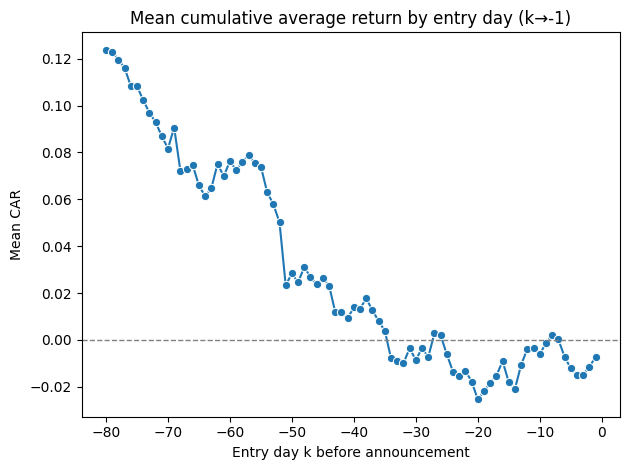

In [54]:

if best_row is not None:
    print(f"Best entry k = {int(best_row['k_entry'])}, mean CAR = {best_row['mean_CAR']:.4f}, n = {int(best_row['n_events'])}, t = {best_row['tstat'] if not np.isnan(best_row['tstat']) else float('nan')}")
else:
    print("No CAR results (insufficient data).")

sns.lineplot(data=car_df, x='k_entry', y='mean_CAR', marker='o')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title('Mean cumulative average return by entry day (k→-1)')
plt.xlabel('Entry day k before announcement')
plt.ylabel('Mean CAR')
plt.tight_layout()
plt.show()


## 9. Statistical Significance
We apply a one-sided t-test (at 10% significance) to identify which entry windows provide statistically reliable alpha.
*   **Hypothesis**: Inclusion leads to positive price pressure, so we test for CAR > 0.

In [55]:
tcrit_10_one_sided = 1.35  
car_df['sig_10pct_one_sided'] = car_df['tstat'] >= tcrit_10_one_sided

sig_rows = car_df[car_df['sig_10pct_one_sided']].copy()

display(car_df[['k_entry', 'mean_CAR', 'tstat', 'n_events', 'sig_10pct_one_sided']])
print(f"One-sided 10% crit (approx): {tcrit_10_one_sided}")
print("k passing one-sided 10% (positive effect):")
display(sig_rows[['k_entry', 'mean_CAR', 'tstat', 'n_events']])


,k_entry,mean_CAR,tstat,n_events,sig_10pct_one_sided
0,-80,0.123766,1.716721,40,True
1,-79,0.122885,1.721156,40,True
2,-78,0.119591,1.660926,40,True
3,-77,0.116017,1.618887,40,True
4,-76,0.108353,1.557186,40,True
...,...,...,...,...,...
75,-5,-0.012132,-1.477068,40,False
76,-4,-0.014866,-2.213276,40,False
77,-3,-0.014803,-2.233008,40,False
78,-2,-0.011437,-2.169468,40,False


One-sided 10% crit (approx): 1.35
k passing one-sided 10% (positive effect):


,k_entry,mean_CAR,tstat,n_events
0,-80,0.123766,1.716721,40
1,-79,0.122885,1.721156,40
2,-78,0.119591,1.660926,40
3,-77,0.116017,1.618887,40
4,-76,0.108353,1.557186,40
5,-75,0.108210,1.568652,40
6,-74,0.102342,1.513234,40
7,-73,0.096960,1.470713,40
8,-72,0.092912,1.361370,40
9,-71,0.086972,1.399089,40


## 10. Conclusion & Takeaways
**The Verdict**:
This summary identifies the optimal "Entry Day" ($k$) that maximizes risk-adjusted return.

*   **Early Window (<-60)**: Represents long-term predictive modeling.
*   **Late Window (>-60)**: Represents reactive or near-term positioning.

If the peak CAR occurs in the **Early Window**, it confirms that the market successfully predicts and positions for these additions months in advance.

In [56]:
if 'car_df' not in globals() or car_df.empty:
    print('No CAR results to summarize.')
else:
    best = car_df.loc[car_df['mean_CAR'].idxmax()]
    early = car_df[car_df['k_entry'] <= -60]
    late = car_df[(car_df['k_entry'] > -60) & (car_df['k_entry'] <= -1)]
    def fmt(row):
        return f"k={int(row['k_entry'])}, mean_CAR={row['mean_CAR']:.4f}, t={row['tstat'] if not (row['tstat'] != row['tstat']) else float('nan')}, n={int(row['n_events'])}"
    print('Peak CAR:', fmt(best))
    if not early.empty:
        eb = early.loc[early['mean_CAR'].idxmax()]
        print('Best k<=-60:', fmt(eb))
    if not late.empty:
        lb = late.loc[late['mean_CAR'].idxmax()]
        print('Best -60<k<=-1:', fmt(lb))
    if best['k_entry'] <= -60:
        print('Peak occurs 60+ days before effective date.')
    else:
        print('Peak occurs inside 60 days before effective date.')



Peak CAR: k=-80, mean_CAR=0.1238, t=1.7167206211169526, n=40
Best k<=-60: k=-80, mean_CAR=0.1238, t=1.7167206211169526, n=40
Best -60<k<=-1: k=-57, mean_CAR=0.0789, t=1.5900181080472993, n=40
Peak occurs 60+ days before effective date.
